# Introduction

This Notebook analyses the Medical Insurance Cost Dataset.

# Data analysis

In [1]:
import argparse
import io
import os
import sys
import textwrap
from pathlib import Path

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_csv("/kaggle/input/medical-insurance-cost-dataset/insurance.csv")

## Glimpse the data

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.shape

(1338, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


All the columns and rows are filled in.

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Data visualisation

## Histograms

We will show the distribution of age, bmi, children, and charges.

In [7]:
def plot_hist(df: pd.DataFrame, col: str):
    plt.figure()
    df[col].hist(bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

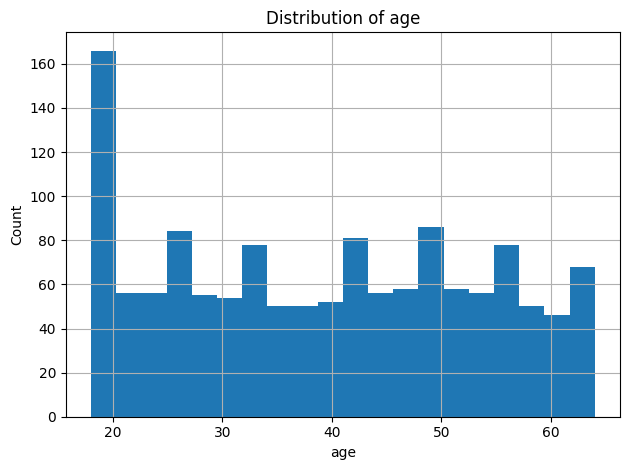

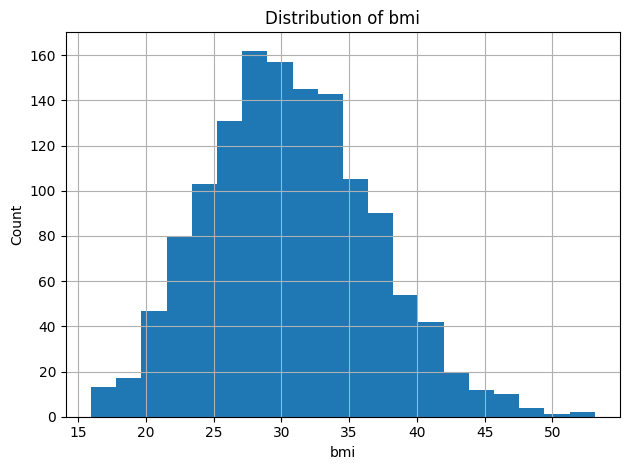

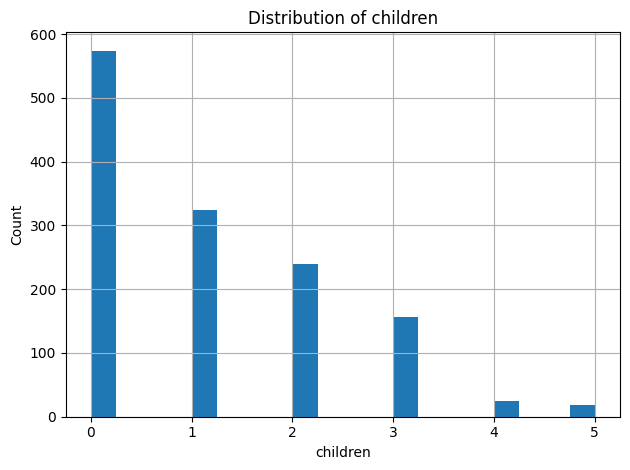

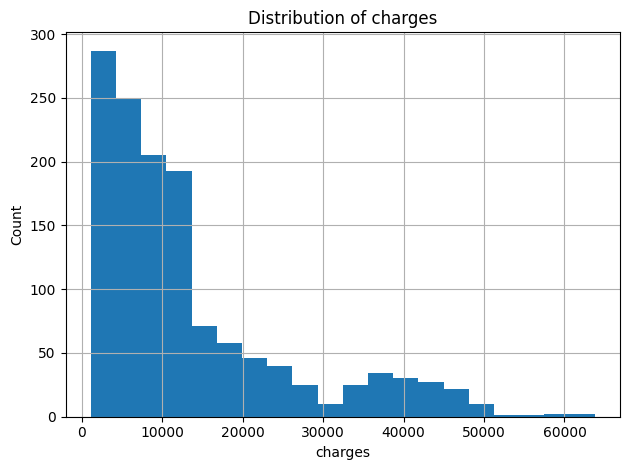

In [8]:
for col in ["age", "bmi", "children", "charges"]:
    plot_hist(df, col)

## Categorical count

We will show the count of classes for the sex, smoker, and region categories.

In [9]:
def plot_cat_counts(df: pd.DataFrame, col: str):
    plt.figure()
    df[col].value_counts(dropna=False).plot(kind="bar")
    plt.title(f"Counts by {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

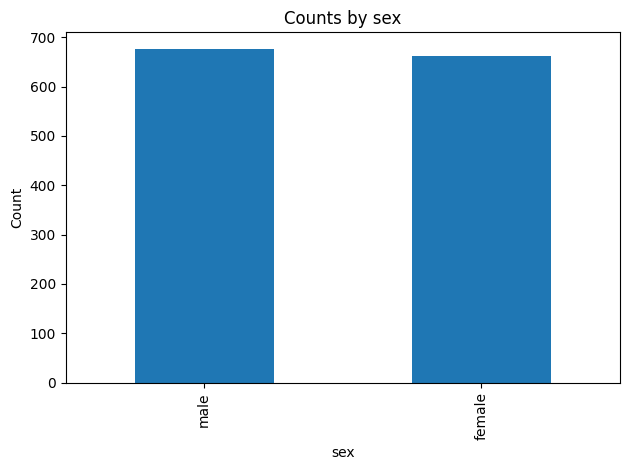

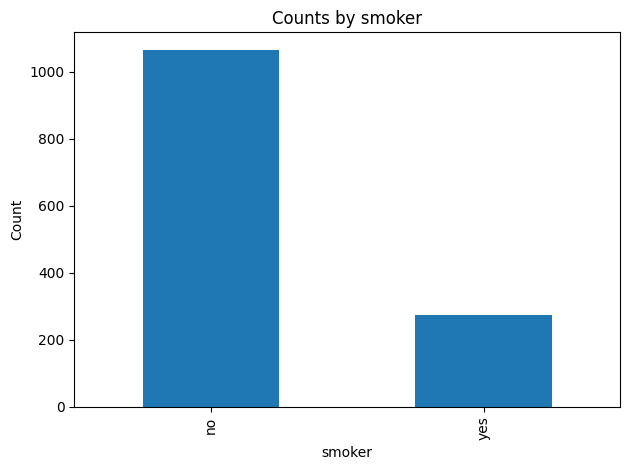

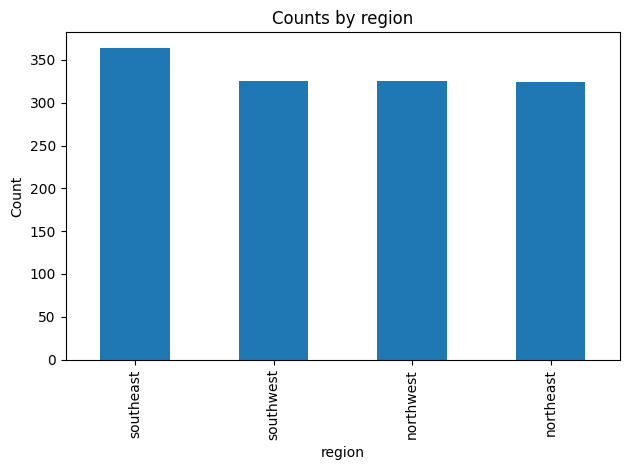

In [10]:
for col in ["sex", "smoker", "region"]:
    plot_cat_counts(df, col)

# Scatter plots

We will show the scatter plots of charges vs. age/bmi, and # of children.

In [11]:
def plot_scatter(df: pd.DataFrame, xcol: str, ycol: str):
    plt.figure()
    plt.scatter(df[xcol], df[ycol])
    plt.title(f"{xcol} vs {ycol}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.tight_layout()
    plt.show()

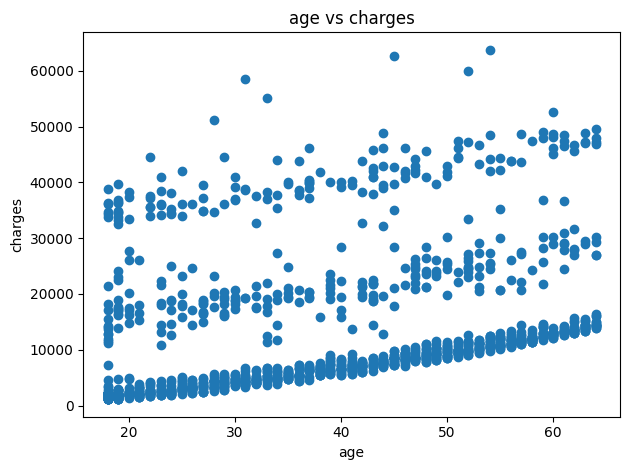

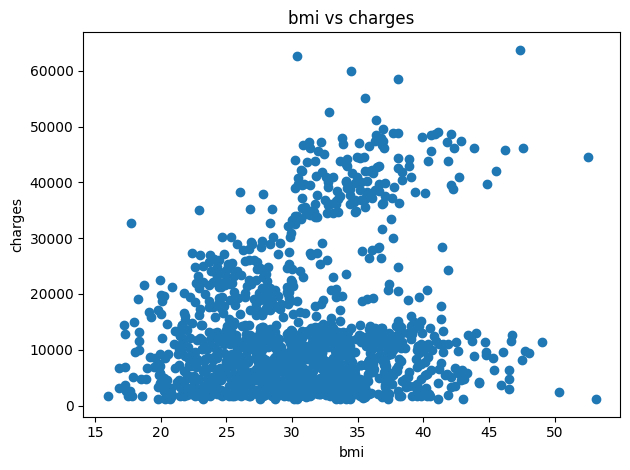

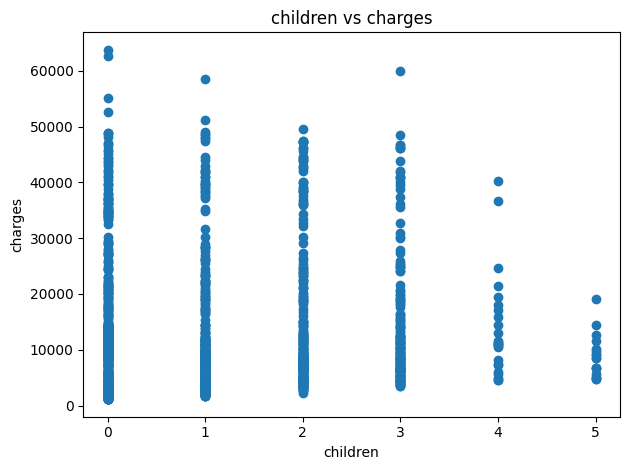

In [12]:
for x in ["age", "bmi", "children"]:
    plot_scatter(df, x, "charges")

# Boxplots

We will show the distribution with boxplots for charges by smoker.

In [13]:
def plot_box_by_group(df: pd.DataFrame, value_col: str, group_col: str):
    plt.figure()
    groups = df.groupby(group_col)[value_col].apply(list)
    positions = range(1, len(groups) + 1)
    plt.boxplot(groups.tolist(), positions=list(positions), labels=list(groups.index))
    plt.title(f"{value_col} by {group_col}")
    plt.xlabel(group_col)
    plt.ylabel(value_col)
    plt.tight_layout()
    plt.show()

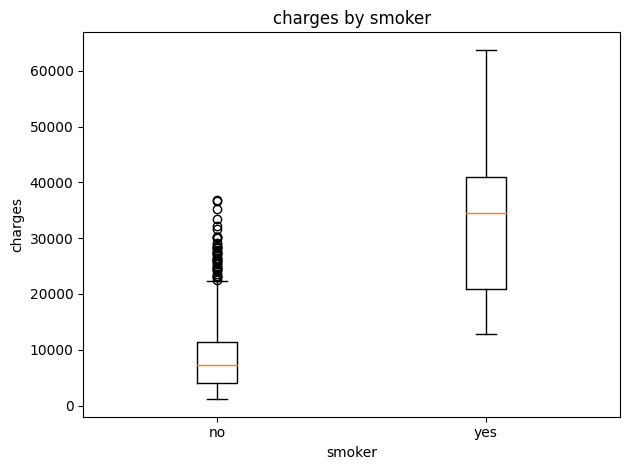

In [14]:
plot_box_by_group(df, "charges", "smoker")

## Correlation heatmap

We show the correlation matrix (with a heatmap) for the numerical features.

In [15]:
def plot_corr_heatmap(df: pd.DataFrame, numeric_cols: list[str]):
    corr = df[numeric_cols].corr()
    plt.figure()
    plt.imshow(corr, interpolation='nearest')
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha="right")
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title("Correlation heatmap (numeric)")
    for (i, j) in itertools.product(range(len(numeric_cols)), range(len(numeric_cols))):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

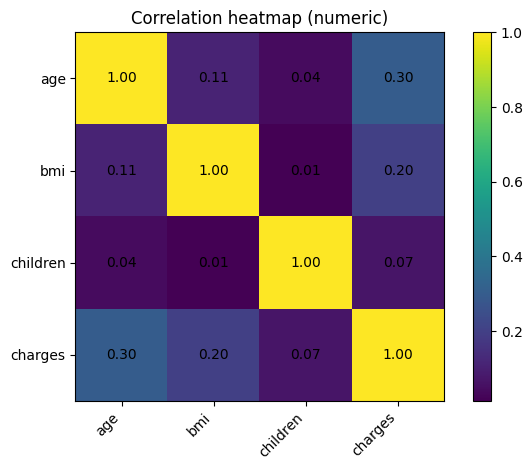

In [16]:
plot_corr_heatmap(df, ["age", "bmi", "children", "charges"])

# Train models


We will build three regression models to predict the charges, as following:
- LinearRegression
- RandomForestRegressor
- GradientBoostingRegressor

## Set the target vector and features matrix

In [17]:
target = "charges"
features = ["age", "sex", "bmi", "children", "smoker", "region"]
X = df[features].copy()
y = df[target].copy()

## Perform train-valid-test split

In [18]:
# Train/valid/test = 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Of the remaining 80%, split 25% to valid -> 20% overall
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

## Preprocessing

We process the numerical features and the categorical features.

In [19]:
def build_preprocessor(numeric_features: list[str], categorical_features: list[str]) -> ColumnTransformer:
    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(with_mean=True, with_std=True), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ]
    )
    return preprocess

In [20]:
numeric_features = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]

preprocess = build_preprocessor(numeric_features, categorical_features)

## Prepare the models

We will check three models:
- LinearRegression
- RandomForestRegressor
- GradientBoostingRegressor

In [21]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42),
    "GradientBoostingRegressor": RandomForestRegressor(n_estimators=300, random_state=42)
}

## Run training and evaluation

In [22]:
def evaluate(pipe: Pipeline, X: pd.DataFrame, y: pd.Series, split: str) -> dict:
    preds = pipe.predict(X)
    return {
        "split": split,
        "MAE": mean_absolute_error(y, preds),
        "RMSE": mean_squared_error(y, preds, squared=False),
        "R2": r2_score(y, preds),
    }

In [23]:
results = []
fitted = {}
feature_names = None

for name, est in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", est)])
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

    # Evaluate
    results.append({"model": name, **evaluate(pipe, X_train, y_train, "train")})
    results.append({"model": name, **evaluate(pipe, X_valid, y_valid, "valid")})
    results.append({"model": name, **evaluate(pipe, X_test, y_test, "test")})

    # Get feature names after preprocessing (for insights)
    ohe = pipe.named_steps["preprocess"].named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names = numeric_features + cat_names

    # Save model-specific insights
    if name == "LinearRegression":
        lin = pipe.named_steps["model"]
        coefs = pd.Series(lin.coef_, index=feature_names).sort_values(ascending=False)
        print("LinearRegression: regression coeficients")
        print(coefs)

    if name == "RandomForest":
        rf = pipe.named_steps["model"]
        imps = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
        print("\n\nRandomForestRegressor: feature importance")
        print(imps)

    if name == "GradientBoostingRegressor":
        rf = pipe.named_steps["model"]
        imps = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
        print("\n\GradientBoostingRegressor: feature importance")
        print(imps)

LinearRegression: regression coeficients
smoker_yes          11624.940702
age                  3568.652415
bmi                  2092.554996
children              500.136614
region_northeast      451.018181
sex_female             78.965281
region_northwest       -9.536098
sex_male              -78.965281
region_southeast     -143.286085
region_southwest     -298.195998
smoker_no          -11624.940702
dtype: float64


RandomForestRegressor: feature importance
smoker_yes          0.343344
smoker_no           0.263496
bmi                 0.209203
age                 0.139882
children            0.019759
region_northeast    0.005589
region_northwest    0.004664
region_southeast    0.004071
sex_male            0.003689
sex_female          0.003525
region_southwest    0.002779
dtype: float64

\GradientBoostingRegressor: feature importance
smoker_yes          0.344420
smoker_no           0.262503
bmi                 0.209536
age                 0.139670
children            0.019714
region_nor

## Evaluation metrics

In [24]:
# Save metrics
results_df = pd.DataFrame(results)
# Order columns nicely
results_df = results_df[["model", "split", "MAE", "RMSE", "R2"]]
results_df.head(10)

,model,split,MAE,RMSE,R2
0,LinearRegression,train,4054.281279,5878.650181,0.745658
1,LinearRegression,valid,4574.566189,6766.880761,0.728291
2,LinearRegression,test,4166.858723,5809.796054,0.782583
3,RandomForest,train,955.591372,1740.635486,0.977701
4,RandomForest,valid,2833.898093,5474.491992,0.822166
5,RandomForest,test,2387.829552,4523.298887,0.868210
6,GradientBoostingRegressor,train,959.222232,1744.671162,0.977598
7,GradientBoostingRegressor,valid,2823.314761,5465.216835,0.822768
8,GradientBoostingRegressor,test,2385.335484,4532.301326,0.867685


Let's see which model is the best.

In [25]:
# Pick best model by valid RMSE
best_row = results_df.query("split == 'valid'").sort_values("RMSE", ascending=True).iloc[0]
best_name = best_row["model"]
best_pipe = fitted[best_name]

print(list(results_df.columns))
print("Best row: ", list(best_row))
print("\nBest model: ", best_name)


['model', 'split', 'MAE', 'RMSE', 'R2']
Best row:  ['GradientBoostingRegressor', 'valid', 2823.3147610950055, 5465.2168349143485, 0.8227680093232727]

Best model:  GradientBoostingRegressor


## Testing metrics

In [26]:
def plot_pred_vs_actual(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.xlabel("Actual charges")
    plt.ylabel("Predicted charges")
    plt.title(title)
    lim_min = float(min(np.min(y_true), np.min(y_pred)))
    lim_max = float(max(np.max(y_true), np.max(y_pred)))
    plt.plot([lim_min, lim_max], [lim_min, lim_max])
    plt.tight_layout()
    plt.show()

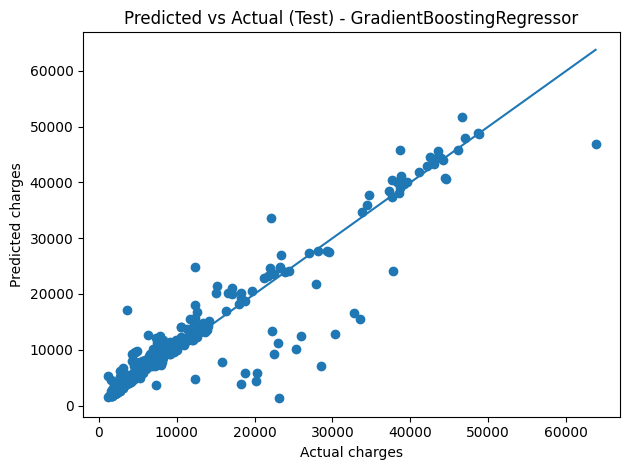

In [27]:
# Pred vs Actual on test
preds_test = best_pipe.predict(X_test)
plot_pred_vs_actual(
    y_true=y_test.values,
    y_pred=preds_test,
    title=f"Predicted vs Actual (Test) - {best_name}",
)

# Multiple models performance comparison and model stacking


Let's compare multiple models performance and create a stacking model with the best three candidates.

The complete list of models we will use for this expercise is:
- LinearRegression
- RandomForestRegressor
- GradientBoostingRegressor
- SVR
- ElasticNet
- KNeighborsRegressor
- HistGradientBoostingRegressor
- HuberRegressor

Let's define now preprocessing steps.

In [28]:
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns


# Preprocessing
pre_scaled = ColumnTransformer([
    ("num", StandardScaler(with_mean=True), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Trees don't need scaling; pass numeric through
pre_tree = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")

In [29]:

cvr = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

candidates = {
    "lr": Pipeline([("pre", pre_scaled), ("m", LinearRegression())]),
    "rfr": Pipeline([("pre", pre_tree), ("m", RandomForestRegressor())]),
    "gbr": Pipeline([("pre", pre_tree), ("m", GradientBoostingRegressor())]),
    "svr": Pipeline([("pre", pre_scaled), ("m", SVR())]),
    "enet": Pipeline([("pre", pre_scaled), ("m", ElasticNet(max_iter=2000))]),
    "knn": Pipeline([("pre", pre_scaled), ("m", KNeighborsRegressor())]),
    "hgb": Pipeline([("pre", pre_tree), ("m", HistGradientBoostingRegressor())]),
    "huber": Pipeline([("pre", pre_scaled), ("m", HuberRegressor(max_iter=2000))]),
}


Parameters space for the models.

In [30]:
param_space = {
    "lr":   {"m__fit_intercept": [True, False],
             "m__positive": [False, True]},
    "rfr":   {"m__n_estimators": [300, 600, 1000],
             "m__max_depth": [None, 8, 12, 16, 24],
             "m__min_samples_leaf": [1, 2, 4, 10],
             "m__max_features": ["sqrt", "log2", 1.0]},
    "gbr":  {"m__learning_rate": [0.03, 0.05, 0.1],
             "m__n_estimators": [300, 600, 1000],
             "m__max_depth": [2, 3, 4],
             "m__min_samples_leaf": [1, 5, 10],
             "m__subsample": [0.6, 0.8, 1.0],
             "m__max_features": ["sqrt", "log2", None]},
    "svr": {"m__C": [0.3, 1, 3, 10], "m__gamma": ["scale", 0.01, 0.1], "m__epsilon": [0.01, 0.1, 0.3]},
    "enet": {"m__alpha": np.logspace(-4, 1, 8), "m__l1_ratio": np.linspace(0, 1, 6)},
    "knn": {"m__n_neighbors": [3,5,7,11,19], "m__weights": ["uniform","distance"]},
    "hgb": {"m__learning_rate": [0.03, 0.05, 0.1],
            "m__max_depth": [None, 6, 10],
            "m__max_leaf_nodes": [31, 63, 127],
            "m__min_samples_leaf": [10, 20, 50]},
    "huber": {"m__epsilon": [1.1, 1.35, 1.5], "m__alpha": np.logspace(-6, -2, 5)},
}

Run hyperparameter tuning for all models. We will use cross-validation with 5 splits and RandomizedSearchCV for this collection of models with many hyperparam. Randomized search is better than GridSearch since will explore better the parameter space.

In [31]:
results = []
for name, pipe in candidates.items():
    search = RandomizedSearchCV(
        pipe, 
        param_distributions=param_space[name],
        n_iter=20, 
        cv=cvr, 
        scoring=scorer, 
        n_jobs=-1, 
        random_state=42
    )
    search.fit(X, y)
    results.append((name, search.best_score_, search.best_params_, search.best_estimator_))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e+10, tolerance: 1.520e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

Let's check the best model and model parameters.

In [32]:
best = sorted(results, key=lambda x: x[1], reverse=True)[0]  # less negative MSE is better => reverse=True
best_name, best_cv, best_params, best_est = best
print(f"Best: {best_name}  CV-MSE: {best_cv:.4f}  Params: {best_params}")

Best: gbr  CV-MSE: -20415663.8026  Params: {'m__subsample': 0.6, 'm__n_estimators': 300, 'm__min_samples_leaf': 10, 'm__max_features': None, 'm__max_depth': 2, 'm__learning_rate': 0.03}


Let's see which models were in top 3.

In [33]:
for i in range(0, 3):
    best = sorted(results, key=lambda x: x[1], reverse=True)[i]  # less negative MSE is better => reverse=True
    best_name, best_cv, best_params, best_est = best
    print(f"Best ({i + 1}): {best_name}  CV-MSE: {best_cv:.4f}  Params: {best_params}")

Best (1): gbr  CV-MSE: -20415663.8026  Params: {'m__subsample': 0.6, 'm__n_estimators': 300, 'm__min_samples_leaf': 10, 'm__max_features': None, 'm__max_depth': 2, 'm__learning_rate': 0.03}
Best (2): rfr  CV-MSE: -20667570.8972  Params: {'m__n_estimators': 300, 'm__min_samples_leaf': 10, 'm__max_features': 1.0, 'm__max_depth': 8}
Best (3): hgb  CV-MSE: -20936313.6545  Params: {'m__min_samples_leaf': 50, 'm__max_leaf_nodes': 127, 'm__max_depth': None, 'm__learning_rate': 0.05}


Let's now create a stacked model with these 3 best models.

In [34]:
stack = StackingRegressor(
    estimators=[("gbr", candidates["gbr"]), ("rfr", candidates["rfr"]), ("hgb", candidates["hgb"])],
    final_estimator=ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=2000),
    passthrough=False
)
stack.fit(X, y)

StackingRegressor(estimators=[('gbr',
                               Pipeline(steps=[('pre',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('cat',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 Index(['sex', 'smoker', 'region'], dtype='object'))])),
                                               ('m',
                                                GradientBoostingRegressor())])),
                              ('rfr',
                               Pipeline(steps=[('pre',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('cat',
                                                                                 OneHot...
                                                                                 Index(['sex', 'smoker', 'region'], dtype='object'))])),
                                               ('m',
                                                RandomForestRegressor())])),
                              ('hgb',
                               Pipeline(steps=[('pre',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('cat',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 Index(['sex', 'smoker', 'region'], dtype='object'))])),
                                               ('m',
                                                HistGradientBoostingRegressor())]))],
                  final_estimator=ElasticNet(alpha=0.01, l1_ratio=0.2,
                                             max_iter=2000))

Let's evaluate this model.

In [35]:
from sklearn.model_selection import KFold, cross_validate, train_test_split

est = stack

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

cvres = cross_validate(
    est, X, y,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

def show_cv_results(res):
    def fmt(name, vals, negate=False):
        vals = -vals if negate else vals
        return f"{name}: {vals.mean():.4f} ± {vals.std():.4f}"
    print("CV test metrics (mean ± std):")
    print(" ", fmt("RMSE", res["test_rmse"], negate=True))
    print(" ", fmt("MAE",  res["test_mae"],  negate=True))
    print(" ", fmt("R²",   res["test_r2"],   negate=False))
    # (optional) peek at train scores to gauge over/underfit
    print("\nCV train metrics:")
    print(" ", fmt("RMSE", res["train_rmse"], negate=True))
    print(" ", fmt("MAE",  res["train_mae"],  negate=True))
    print(" ", fmt("R²",   res["train_r2"],   negate=False))

show_cv_results(cvres)

# ---- Optional: hold-out set for a final check ----
# (Skip this if you already have X_train/X_test.)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
est.fit(X_tr, y_tr)
pred = est.predict(X_te)

rmse = mean_squared_error(y_te, pred, squared=False)
mae  = mean_absolute_error(y_te, pred)
r2   = r2_score(y_te, pred)

print("\nHold-out test metrics:")
print(f" RMSE: {rmse:.4f}")
print(f" MAE : {mae:.4f}")
print(f" R²  : {r2:.4f}")

CV test metrics (mean ± std):
  RMSE: 4585.4145 ± 318.1692
  MAE: 2519.7280 ± 144.3660
  R²: 0.8522 ± 0.0328

CV train metrics:
  RMSE: 3300.0461 ± 170.5530
  MAE: 1783.8032 ± 105.7454
  R²: 0.9255 ± 0.0073

Hold-out test metrics:
 RMSE: 4315.7517
 MAE : 2357.3011
 R²  : 0.8800


# Final Remarks

We performed a preliminary data analysis, followed by an extensive exploratory data analysis.
Then, we compared the performance of three models:
- LinearRegression
- RandomForestRegressor
- GradientBoostingRegressor

GradientBoostingRegressor was the best model.

Then we performed hyperparameter tuning for more models:
- LinearRegression
- RandomForestRegressor
- GradientBoostingRegressor
- SVR
- ElasticNet
- KNeighborsRegressor
- HistGradientBoostingRegressor
- HuberRegressor

After running hyperparameter tuning, we selected the best 3 models and created a stacked model using ElasticNet as the stacker.
We also evaluated the stacked model performance.